In [76]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io

In [77]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)
path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [78]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [79]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"?¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> ? \xc2\xbf puedo tomar prestado este libro ? <end>'


In [80]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [81]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [82]:
def tokenize(lang):
    lang_tokenize = keras.preprocessing.text.Tokenizer(filters=" ")
    lang_tokenize.fit_on_texts(lang)
    tensor = lang_tokenize.texts_to_sequences(lang)
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding="post")
    return tensor, lang_tokenize

In [83]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [84]:
# num_examples = 100000
target_tensor, input_tensor, targ_lang, inp_lang = load_dataset(path_to_file)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [85]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d =====> %s" % (t, lang.index_word[t]))

In [86]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 =====> <start>
4 =====> i
21 =====> was
64 =====> about
7 =====> to
2096 =====> suggest
6 =====> the
295 =====> same
289 =====> thing
3 =====> .
2 =====> <end>

Target Language; index to word mapping
1 =====> <start>
631 =====> estuve
9 =====> a
461 =====> punto
8 =====> de
8877 =====> sugerir
20 =====> lo
163 =====> mismo
3 =====> .
2 =====> <end>


In [87]:
buffer_size = len(input_tensor_train)
batch_size = 512
steps_per_epoch = len(input_tensor_train) // batch_size
embedding_dim = 512
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

In [88]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)

In [89]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 17]), TensorShape([256, 20]))

In [90]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.encoding_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

In [91]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
sample_output.shape, sample_hidden.shape

(TensorShape([256, 17, 1024]), TensorShape([256, 1024]))

In [92]:
class BahdanuAttention(keras.layers.Layer):
    def __init__(self, units):
        super(BahdanuAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [93]:
attention_layer = BahdanuAttention(20)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
attention_result.shape, attention_weights.shape

(TensorShape([256, 1024]), TensorShape([256, 17, 1]))

In [94]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(self.decoding_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanuAttention(self.decoding_units)

    def call(self, x, hidden, encoding_output):
        context_vector, attention_weights = self.attention(hidden, encoding_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [95]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, batch_size)
sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_size, 1)), sample_hidden, sample_output)
sample_decoder_output.shape

TensorShape([256, 20708])

In [96]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [97]:
@tf.function
def train_step(input, target, encoding_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        encoding_output, encoding_hidden = encoder(input, encoding_hidden)
        decoding_hidden = encoding_hidden
        decoding_input = tf.expand_dims([targ_lang.word_index["<start>"]] * batch_size, 1)
        
        for t in range(1, target.shape[1]):
            predictions, decoding_hidden, _ = decoder(decoding_input, decoding_hidden, encoding_output)
            loss += loss_function(target[:, t], predictions)
            decoding_input = tf.expand_dims(target[:, t], 1)
        
        batch_loss = (loss / int(target.shape[1]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

In [98]:
import time

epochs = 20

for epoch in range(epochs):
    start = time.time()
    encoding_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (input, target)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoding_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f"Epoch : {epoch+1}    Batch : {batch}    Loss : {batch_loss.numpy()}")

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch : 1    Batch : 0    Loss : 3.674436569213867
Epoch : 1    Batch : 100    Loss : 1.9611549377441406
Epoch : 1    Batch : 200    Loss : 1.8098548650741577
Epoch : 1    Batch : 300    Loss : 1.7883329391479492
Time taken for 1 epoch 136.57321643829346 sec

Epoch : 2    Batch : 0    Loss : 1.7404159307479858
Epoch : 2    Batch : 100    Loss : 1.7029027938842773
Epoch : 2    Batch : 200    Loss : 1.5274641513824463
Epoch : 2    Batch : 300    Loss : 1.5194475650787354
Time taken for 1 epoch 114.26237964630127 sec

Epoch : 3    Batch : 0    Loss : 1.451350450515747
Epoch : 3    Batch : 100    Loss : 1.35951828956604
Epoch : 3    Batch : 200    Loss : 1.3536344766616821
Epoch : 3    Batch : 300    Loss : 1.2660406827926636
Time taken for 1 epoch 114.7772045135498 sec

Epoch : 4    Batch : 0    Loss : 1.2290763854980469
Epoch : 4    Batch : 100    Loss : 1.1705677509307861
Epoch : 4    Batch : 200    Loss : 1.1622554063796997
Epoch : 4    Batch : 300    Loss : 1.0734319686889648
Time tak

In [99]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(" ")]
    inputs = keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding="post")
    inputs = tf.convert_to_tensor(inputs)

    result = ""

    hidden = [tf.zeros((1, units))]
    encoding_output, encoding_hidden = encoder(inputs, hidden)
    decoding_hidden = encoding_hidden
    decoding_input = tf.expand_dims([targ_lang.word_index["<start>"]], 0)

    for t in range(max_length_targ):
        prediction, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_output)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        prediction_id = tf.argmax(prediction[0]).numpy()
        result += targ_lang.index_word[prediction_id] + " "
        
        if targ_lang.index_word[prediction_id] == "<end>":
            return result, sentence, attention_plot
        
        decoding_input = tf.expand_dims([prediction_id], 0)
    return result, sentence, attention_plot

In [100]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [101]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> moon sun <end>
Predicted translation: la luna enemigo . <end> 


C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\ozing\miniconda3\envs\handson-ml2\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


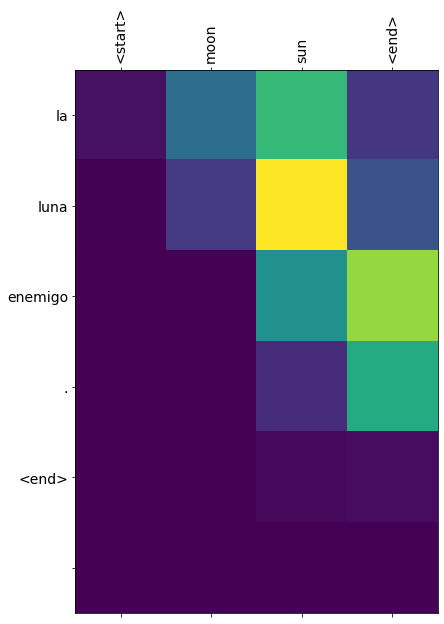

In [118]:
translate(u"moon sun")